In [ ]:
# --- Common Setup and Imports ---
import os
import zipfile
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import librosa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import soundfile as sf # For dummy audio creation if zips are missing
# Removed pydub imports: from pydub import AudioSegment, from pydub.silence import split_on_silence

!pip install resampy

# Common Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("All necessary libraries imported and seed set for reproducibility.")

All necessary libraries imported and seed set for reproducibility.


In [ ]:
# --- Dataset Unzipping and Initial Setup (as per your request) ---
print("--- Dataset Unzipping and Initial Setup ---")

# Define paths for all datasets. Assume they are uploaded as zip files.
# You might need to adjust these paths based on where you upload them in your environment.
emodb_zip_path = "/content/emodb.zip"
ravdess_zip_path = "/content/Ravdess.zip"
savee_zip_path = ""
crema_zip_path = ""
# Add paths for Hindi, Kannada, Bengali if you have them as zip files
hindi_zip_path = ""
kannada_zip_path = ""
bengali_zip_path = ""


# Define extraction paths
emodb_extract_path = "/content/emodb_raw"
ravdess_extract_path = "/content/RAVDESS_raw"
savee_extract_path = "/content/SAVEE_raw"
crema_extract_path = "/content/CREMA_D_raw"
hindi_extract_path = ""
kannada_extract_path = ""
bengali_extract_path = ""


# Dictionary to store successful extraction paths for the MTL data collection
extracted_paths_mtl = {}

# Unified dataset directory (will be created, but files won't be moved here by this script)
unified_dataset_path = "/content/combined_unified_dataset_structure" # Renamed to avoid confusion
os.makedirs(unified_dataset_path, exist_ok=True)


# --- Unzip all datasets ---
def perform_unzip(zip_path, extract_path, dataset_name):
    global extracted_paths_mtl # Declare global to modify the dictionary
    print(f"Unzipping {dataset_name}...")
    try:
        os.makedirs(extract_path, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Unzipped {dataset_name} to: {extract_path}")
        extracted_paths_mtl[dataset_name] = extract_path # Store successful path
    except FileNotFoundError:
        print(f"Warning: {zip_path} not found. Skipping {dataset_name} dataset.")
        # Optionally, create dummy data if the zip is missing
        dummy_data_path = os.path.join(extract_path, 'dummy_audio')
        os.makedirs(dummy_data_path, exist_ok=True)
        # Create a few dummy WAV files for basic functionality
        for i in range(3):
            dummy_file = os.path.join(dummy_data_path, f"dummy_{dataset_name}_{i}.wav")
            sf.write(dummy_file, np.zeros(16000), 16000) # 1 second of silence
        print(f"Created dummy audio files for {dataset_name} in {dummy_data_path}.")
        extracted_paths_mtl[dataset_name] = extract_path # Still add path, but it points to dummy
    except Exception as e:
        print(f"Error unzipping {dataset_name} from {zip_path}: {e}. Skipping.")

perform_unzip(emodb_zip_path, emodb_extract_path, 'EMODB')
perform_unzip(ravdess_zip_path, ravdess_extract_path, 'RAVDESS')
perform_unzip(savee_zip_path, savee_extract_path, 'SAVEE')
perform_unzip(crema_zip_path, crema_extract_path, 'CREMA-D')
perform_unzip(hindi_zip_path, hindi_extract_path, 'Hindi')
perform_unzip(kannada_zip_path, kannada_extract_path, 'Kannada')
perform_unzip(bengali_zip_path, bengali_extract_path, 'Bengali')


# Load CREMA-D Demographics Metadata (if CREMA-D was unzipped)
demographics_df_crema = None
if 'CREMA-D' in extracted_paths_mtl:
    crema_actual_path = extracted_paths_mtl['CREMA-D']
    demographics_file_name = 'VideoDemographics.csv'
    demographics_path = os.path.join(crema_actual_path, demographics_file_name)

    # Check common nested path for CREMA-D (sometimes it extracts to CREMA-D/CREMA-D)
    if not os.path.exists(demographics_path):
        demographics_path_nested = os.path.join(crema_actual_path, 'CREMA-D', demographics_file_name)
        if os.path.exists(demographics_path_nested):
            demographics_path = demographics_path_nested

    if os.path.exists(demographics_path):
        try:
            demographics_df_crema = pd.read_csv(demographics_path)
            demographics_df_crema['ActorID'] = demographics_df_crema['ActorID'].astype(str)
            print(f"\nCREMA-D Demographics metadata loaded from: {demographics_path}")
        except Exception as e:
            print(f"Error loading CREMA-D demographics: {e}")
            demographics_df_crema = None
    else:
        print(f"\nWarning: CREMA-D Demographics file '{demographics_file_name}' not found. Accent mapping might be less precise.")

print("\nDataset unzipping/dummy data creation complete for all specified zips.")

--- Dataset Unzipping and Initial Setup ---
Unzipping EMODB...
Unzipped EMODB to: /content/emodb_raw
Unzipping RAVDESS...
Unzipped RAVDESS to: /content/RAVDESS_raw
Unzipping SAVEE...
Unzipped SAVEE to: /content/SAVEE_raw
Unzipping CREMA-D...
Unzipped CREMA-D to: /content/CREMA_D_raw
Unzipping Hindi...
Created dummy audio files for Hindi in dummy_audio.
Unzipping Kannada...
Created dummy audio files for Kannada in dummy_audio.
Unzipping Bengali...
Created dummy audio files for Bengali in dummy_audio.


Dataset unzipping/dummy data creation complete for all specified zips.


In [ ]:
# --- 1. Unified Data Loading and Labeling ---
print("--- Unified Data Loading and Labeling ---")

def collect_audio_and_labels(dataset_name, dataset_path, demographics_df=None):
    audio_files = []
    emotions = []
    accents = []
    genders = []
    print(f"\nCollecting data for {dataset_name} from: {dataset_path}")

    # Map dataset structure to actual audio files
    # These are subdirectories *within* the extracted_path_mtl[dataset_name]
    wav_subdirs = {
        'RAVDESS': 'Audio_Speech_Actors_01-24',
        'SAVEE': 'all', # Corrected based on common SAVEE structure
        'EMODB': 'wav',
        'CREMA-D': 'AudioWAV',
        'Hindi': 'hi/clips', # Adjust based on actual unzipped structure
        'Kannada': '', # Adjust based on actual unzipped structure, might be top-level
        'Bengali': '', # Adjust based on actual unzipped structure, might be top-level
    }

    # Determine the actual path to audio files
    actual_data_path = dataset_path
    if dataset_name in wav_subdirs and os.path.exists(os.path.join(dataset_path, wav_subdirs[dataset_name])):
        actual_data_path = os.path.join(dataset_path, wav_subdirs[dataset_name])
    elif os.path.exists(os.path.join(dataset_path, 'dummy_audio')): # Check for dummy data path
        actual_data_path = os.path.join(dataset_path, 'dummy_audio')
    elif os.path.exists(os.path.join(dataset_path, dataset_name.upper(), wav_subdirs.get(dataset_name, ''))):
         actual_data_path = os.path.join(dataset_path, dataset_name.upper(), wav_subdirs.get(dataset_name, ''))

    file_count = 0
    for root, _, files in os.walk(actual_data_path):
        for file in files:
            if file.endswith('.wav'):
                audio_path = os.path.join(root, file)
                audio_files.append(audio_path)
                file_count += 1

                # Initialize labels to 'unknown' or 'not_applicable'
                emotion_label = 'unknown'
                accent_label = 'unknown'
                gender_label = 'unknown'

                # Labeling Logic based on dataset
                if dataset_name == 'RAVDESS':
                    # RAVDESS: File name format: 03-01-01-01-01-01-01.wav
                    # Modality-Vocal Channel-Emotion-Emotional Intensity-Statement-Repetition-Actor
                    # Emotion codes: 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised
                    parts = file.split('-')
                    if len(parts) >= 3:
                        emotion_code = parts[2]
                        emotion_map = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad',
                                       '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'}
                        emotion_label = emotion_map.get(emotion_code, 'unknown')

                    if len(parts) >= 7:
                        # Actor ID for gender (odd=male, even=female)
                        try:
                            actor_id = int(parts[-1].split('.')[0])
                            gender_label = 'male' if actor_id % 2 != 0 else 'female'
                        except ValueError:
                            pass # Keep as unknown if parsing fails

                    accent_label = 'North American English'

                elif dataset_name == 'SAVEE':
                    # SAVEE: File names like 'DC.wav' (Disgust Calm) or 'a01.wav'
                    # Emotion: 'a' for angry, 'd' for disgust, 'f' for fear, 'h' for happy, 'n' for neutral, 'sa' for sad, 'su' for surprise.
                    # Actor: 'JK', 'JE', 'KL', 'BP' (all male, British)
                    emotion_prefix = file.split('.')[0].lower()
                    if emotion_prefix.startswith('a'): emotion_label = 'angry'
                    elif emotion_prefix.startswith('d'): emotion_label = 'disgust'
                    elif emotion_prefix.startswith('f'): emotion_label = 'fearful'
                    elif emotion_prefix.startswith('h'): emotion_label = 'happy'
                    elif emotion_prefix.startswith('n'): emotion_label = 'neutral'
                    elif emotion_prefix.startswith('sa'): emotion_label = 'sad'
                    elif emotion_prefix.startswith('su'): emotion_label = 'surprised'
                    else: emotion_label = 'unknown'

                    accent_label = 'British English'
                    gender_label = 'male' # All actors in SAVEE are male

                elif dataset_name == 'EMODB':
                    # EMODB: File names like '10_A01_D.wav'
                    # Emotion code is the 3rd char: W=anger, L=boredom, E=disgust, A=fear, F=happy, T=sad, N=neutral.
                    if len(file) >= 6:
                        emotion_code = file[5]
                        emotion_map = {'W':'angry', 'L':'boredom', 'E':'disgust', 'A':'fearful', 'F':'happy', 'T':'sad', 'N':'neutral'}
                        emotion_label = emotion_map.get(emotion_code, 'unknown')

                    # Gender is indicated by the first two digits of the filename:
                    # 03, 08, 09, 10, 11, 12, 13, 14, 15, 16 are male speakers (odd numbers)
                    # 01, 02, 04, 05, 06, 07 are female speakers (even numbers)
                    try:
                        speaker_id = int(file[:2])
                        gender_label = 'male' if speaker_id in [3, 8, 9, 10, 11, 12, 13, 14, 15, 16] else 'female'
                    except ValueError:
                        pass # Keep as unknown
                    accent_label = 'German'

                elif dataset_name == 'CREMA-D':
                    # CREMA-D: File names like '1001_DFA_ANG_XX.wav'
                    # Emotion: ANG=angry, DIS=disgust, FEA=fear, HAP=happy, NEU=neutral, SAD=sad
                    parts = file.split('_')
                    if len(parts) >= 3:
                        emotion_code = parts[2]
                        emotion_map = {'ANG':'angry', 'DIS':'disgust', 'FEA':'fearful', 'HAP':'happy', 'NEU':'neutral', 'SAD':'sad', 'SUR':'surprise'} # Added 'SUR' for completeness
                        emotion_label = emotion_map.get(emotion_code, 'unknown')

                    # Gender and Race (for accent) from demographics_df
                    if len(parts) >= 1:
                        actor_id_str = parts[0]
                        if demographics_df is not None:
                            actor_info = demographics_df[demographics_df['ActorID'] == actor_id_str]
                            if not actor_info.empty:
                                gender_label = actor_info['Sex'].iloc[0].lower() # 'Male' or 'Female'
                                # Simplified accent mapping for CREMA-D based on Race
                                race = actor_info['Race'].iloc[0]
                                if race == 'African American': accent_label = 'African American English'
                                elif race == 'Asian': accent_label = 'Asian English'
                                elif race == 'Caucasian': accent_label = 'Caucasian English'
                                elif race == 'Hispanic': accent_label = 'Hispanic English'
                                else: accent_label = 'CREMA-D English' # Default for others
                            else:
                                gender_label = 'unknown'
                                accent_label = 'CREMA-D English' # Default if actor info missing
                        else:
                            # Fallback for Gender (Actor ID: odd=male, even=female based on typical CREMA-D structure)
                            try:
                                actor_id = int(actor_id_str)
                                gender_label = 'male' if actor_id % 2 != 0 else 'female'
                                accent_label = 'CREMA-D English'
                            except ValueError:
                                gender_label = 'unknown'
                                accent_label = 'unknown'

                elif dataset_name in ['Hindi', 'Kannada', 'Bengali']:
                    # Assuming these datasets primarily provide 'Indian Accent'
                    accent_label = 'Indian'
                    # Emotions and genders are not easily parseable from filename for these,
                    # so they will remain 'unknown' unless specific parsing logic is added.

                emotions.append(emotion_label)
                accents.append(accent_label)
                genders.append(gender_label)

    print(f"Collected {file_count} audio files for {dataset_name}.")
    return audio_files, emotions, accents, genders

# Create a master list of all audio files and their labels
all_audio_files_mtl = []
all_emotions_mtl = []
all_accents_mtl = []
all_genders_mtl = []

for name, path in extracted_paths_mtl.items():
    if name == 'CREMA-D':
        files, emotions, accents, genders = collect_audio_and_labels(name, path, demographics_df_crema)
    else:
        files, emotions, accents, genders = collect_audio_and_labels(name, path)

    all_audio_files_mtl.extend(files)
    all_emotions_mtl.extend(emotions)
    all_accents_mtl.extend(accents)
    all_genders_mtl.extend(genders)

print(f"\nTotal audio files collected across all datasets for MTL: {len(all_audio_files_mtl)}")

# Filter out samples where all labels are 'unknown'
filtered_data = []
for i in range(len(all_audio_files_mtl)):
    if (all_emotions_mtl[i] != 'unknown' or
        all_accents_mtl[i] != 'unknown' or
        all_genders_mtl[i] != 'unknown'):
        filtered_data.append((
            all_audio_files_mtl[i],
            all_emotions_mtl[i],
            all_accents_mtl[i],
            all_genders_mtl[i]
        ))

if not filtered_data:
    print("No valid audio files found after initial collection and filtering. Cannot proceed with MTL training.")
else:
    # Unpack filtered data
    all_audio_files_mtl, all_emotions_mtl, all_accents_mtl, all_genders_mtl = zip(*filtered_data)
    all_audio_files_mtl = list(all_audio_files_mtl)
    all_emotions_mtl = list(all_emotions_mtl)
    all_accents_mtl = list(all_accents_mtl)
    all_genders_mtl = list(all_genders_mtl)

    print(f"Total valid audio files after filtering: {len(all_audio_files_mtl)}")

    # Encode labels
    emotion_le = LabelEncoder()
    accent_le = LabelEncoder()
    gender_le = LabelEncoder()

    encoded_emotions = emotion_le.fit_transform(all_emotions_mtl)
    encoded_accents = accent_le.fit_transform(all_accents_mtl)
    encoded_genders = gender_le.fit_transform(all_genders_mtl)

    num_emotion_classes = len(emotion_le.classes_)
    num_accent_classes = len(accent_le.classes_)
    num_gender_classes = len(gender_le.classes_)

    print(f"\nEmotion Classes ({num_emotion_classes}): {emotion_le.classes_}")
    print(f"Accent Classes ({num_accent_classes}): {accent_le.classes_}")
    print(f"Gender Classes ({num_gender_classes}): {gender_le.classes_}")

--- Unified Data Loading and Labeling ---

Collected 535 audio files for EMODB.

Collected 2880 audio files for RAVDESS.

Collected 480 audio files for SAVEE.

Collected 7442 audio files for CREMA-D.

Collected 9 audio files for Hindi.

Collected 9 audio files for Kannada.

Collected 9 audio files for Bengali.

Total audio files collected across all datasets for MTL: 11364
Total valid audio files after filtering: 11364

Emotion Classes (10): ['angry' 'boredom' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad'
 'surprised' 'unknown']
Accent Classes (5): ['British English' 'CREMA-D English' 'German' 'Indian'
 'North American English']
Gender Classes (3): ['female' 'male' 'unknown']


In [ ]:
# --- 2. Unified Feature Pre-extraction ---
print("\n--- Unified Feature Pre-extraction (MFCC, Delta, Delta-Delta) ---")

# Parameters for common feature extraction
SAMPLE_RATE = 16000
N_MFCC = 40
MAX_PAD_LEN = 200 # Fixed length for features

def extract_common_features_mtl(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC, max_len=MAX_PAD_LEN):
    try:
        # Load audio and handle potential errors
        y, sr = librosa.load(file_path, sr=sr, res_type='kaiser_fast')

        # Pre-emphasis filter
        pre_emphasis = 0.97
        if len(y) > 1:
            y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # --- Silence trimming removed as per user request ---
        # No pydub-based silence trimming will be applied here.
        # The entire audio will be used for feature extraction.

        if len(y) == 0:
            return None

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        # Stack as channels
        combined_features = np.stack([mfcc, delta_mfcc, delta2_mfcc], axis=0) # Shape (3, n_mfcc, time_frames)

        # Pad or truncate time_frames dimension
        if combined_features.shape[2] < max_len:
            pad = max_len - combined_features.shape[2]
            # Pad on the right side
            combined_features = np.pad(combined_features, ((0,0),(0,0),(0,pad)), mode='constant')
        else:
            combined_features = combined_features[:, :, :max_len]

        return combined_features.astype(np.float32)
    except Exception as e:
        print(f"❌ Error extracting common features from {file_path}: {e}")
        return None

if 'filtered_data' in locals() and filtered_data: # Only proceed if there's valid data
    pre_extracted_features = []
    pre_extracted_emotions = []
    pre_extracted_accents = []
    pre_extracted_genders = []

    print("Starting pre-extraction of features for all audio files (without silence removal)...")
    for i, audio_file in enumerate(tqdm(all_audio_files_mtl, desc="Pre-extracting Features")):
        features = extract_common_features_mtl(audio_file)
        if features is not None:
            pre_extracted_features.append(features)
            pre_extracted_emotions.append(encoded_emotions[i])
            pre_extracted_accents.append(encoded_accents[i])
            pre_extracted_genders.append(encoded_genders[i])

    if not pre_extracted_features:
        print("No features successfully pre-extracted. Cannot proceed with MTL training.")
    else:
        pre_extracted_features = np.array(pre_extracted_features)
        pre_extracted_emotions = np.array(pre_extracted_emotions)
        pre_extracted_accents = np.array(pre_extracted_accents)
        pre_extracted_genders = np.array(pre_extracted_genders)

        print(f"Shape of pre-extracted features: {pre_extracted_features.shape}")
        print(f"Number of pre-extracted samples: {len(pre_extracted_features)}")
else:
    print("No valid data to pre-extract features from. Skipping feature extraction.")


--- Unified Feature Pre-extraction (MFCC, Delta, Delta-Delta) ---
Starting pre-extraction of features for all audio files (without silence removal)...


Pre-extracting Features:   0%|          | 0/11364 [00:00<?, ?it/s]

Shape of pre-extracted features: (11364, 3, 40, 200)
Number of pre-extracted samples: 11364


In [ ]:
# --- 3. Custom PyTorch Multi-Task Dataset ---
print("\n--- Custom PyTorch Multi-Task Dataset ---")

if 'pre_extracted_features' in locals() and len(pre_extracted_features) > 0:
    class MultiTaskAudioDataset(Dataset):
        def __init__(self, features, emotions, accents, genders):
            self.features = features
            self.emotions = emotions
            self.accents = accents
            self.genders = genders

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            return (
                torch.tensor(self.features[idx]),
                torch.tensor(self.emotions[idx], dtype=torch.long),
                torch.tensor(self.accents[idx], dtype=torch.long),
                torch.tensor(self.genders[idx], dtype=torch.long)
            )

    mtl_dataset = MultiTaskAudioDataset(
        pre_extracted_features,
        pre_extracted_emotions,
        pre_extracted_accents,
        pre_extracted_genders
    )

    train_size_mtl = int(0.8 * len(mtl_dataset))
    val_size_mtl = len(mtl_dataset) - train_size_mtl
    train_ds_mtl, val_ds_mtl = random_split(mtl_dataset, [train_size_mtl, val_size_mtl])

    BATCH_SIZE = 32
    train_loader_mtl = DataLoader(train_ds_mtl, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader_mtl = DataLoader(val_ds_mtl, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print(f"MTL Train samples: {len(train_ds_mtl)}, Val samples: {len(val_ds_mtl)}")
else:
    print("No pre-extracted features found. Skipping dataset and DataLoader creation.")


--- Custom PyTorch Multi-Task Dataset ---
MTL Train samples: 9091, Val samples: 2273


In [ ]:
# --- 4. Multi-Task CNN Model Architecture ---
print("\n--- Multi-Task CNN Model Architecture ---")

if 'num_emotion_classes' in locals() and 'num_accent_classes' in locals() and 'num_gender_classes' in locals():
    class MultiTaskCNN(nn.Module):
        def __init__(self, num_emotion_classes, num_accent_classes, num_gender_classes, input_shape=(3, N_MFCC, MAX_PAD_LEN)):
            super().__init__()
            self.num_emotion_classes = num_emotion_classes
            self.num_accent_classes = num_accent_classes
            self.num_gender_classes = num_gender_classes

            # Shared Feature Extractor (CNN Backbone)
            # Input: (Batch, 3, 40, 200)
            self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(64)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (64, 20, 100) (approx)

            self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(128)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (128, 10, 50) (approx)

            self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(256)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (256, 5, 25) (approx)

            self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
            self.bn4 = nn.BatchNorm2d(512)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (512, 2, 12) (approx)

            # Calculate flattened size from shared layers
            self._set_flattened_size(input_shape)

            # Task-Specific Heads
            self.emotion_head = nn.Sequential(
                nn.Linear(self.flattened_size, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_emotion_classes)
            )

            self.accent_head = nn.Sequential(
                nn.Linear(self.flattened_size, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_accent_classes)
            )

            self.gender_head = nn.Sequential(
                nn.Linear(self.flattened_size, 256), # Smaller for gender as it's often simpler
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_gender_classes)
            )

        def _set_flattened_size(self, input_shape):
            # Create a dummy input to calculate the output size of the convolutional layers
            with torch.no_grad():
                dummy_input = torch.zeros(1, *input_shape)
                x = self.pool1(F.relu(self.bn1(self.conv1(dummy_input))))
                x = self.pool2(F.relu(self.bn2(self.conv2(x))))
                x = self.pool3(F.relu(self.bn3(self.conv3(x))))
                x = self.pool4(F.relu(self.bn4(self.conv4(x))))
                self.flattened_size = x.view(x.size(0), -1).shape[1]

        def forward(self, x):
            # Shared backbone
            x = self.pool1(F.relu(self.bn1(self.conv1(x))))
            x = self.pool2(F.relu(self.bn2(self.conv2(x))))
            x = self.pool3(F.relu(self.bn3(self.conv3(x))))
            x = self.pool4(F.relu(self.bn4(self.conv4(x))))

            # Flatten for dense layers
            shared_features = x.view(x.size(0), -1)

            # Task-specific heads
            emotion_output = self.emotion_head(shared_features)
            accent_output = self.accent_head(shared_features)
            gender_output = self.gender_head(shared_features)

            return emotion_output, accent_output, gender_output

    device_mtl = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mtl_model = MultiTaskCNN(num_emotion_classes, num_accent_classes, num_gender_classes).to(device_mtl)
    print(f"Using device for MTL: {device_mtl}")
    print("Multi-Task CNN model initialized.")
else:
    print("Skipping Multi-Task CNN model definition due to missing class count information.")


--- Multi-Task CNN Model Architecture ---
Using device for MTL: cpu
Multi-Task CNN model initialized.


In [ ]:
# --- 5. Multi-Task Training Loop ---
print("\n--- Multi-Task Training Loop ---")

if 'mtl_model' in locals() and 'train_loader_mtl' in locals() and 'val_loader_mtl' in locals():
    EPOCHS = 5
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 1e-5

    optimizer_mtl = optim.Adam(mtl_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler_mtl = StepLR(optimizer_mtl, step_size=10, gamma=0.5)

    # Loss functions for each task, ignoring 'unknown' labels
    # Use .transform to get the numerical ID for 'unknown'
    emotion_ignore_index = emotion_le.transform(['unknown'])[0] if 'unknown' in emotion_le.classes_ else -100
    accent_ignore_index = accent_le.transform(['unknown'])[0] if 'unknown' in accent_le.classes_ else -100
    gender_ignore_index = gender_le.transform(['unknown'])[0] if 'unknown' in gender_le.classes_ else -100

    emotion_criterion = nn.CrossEntropyLoss(ignore_index=emotion_ignore_index)
    accent_criterion = nn.CrossEntropyLoss(ignore_index=accent_ignore_index)
    gender_criterion = nn.CrossEntropyLoss(ignore_index=gender_ignore_index)

    best_val_loss_overall = float('inf')
    epochs_no_improve_mtl = 0
    early_stop_patience_mtl = 15

    # Store metrics for plotting
    train_emotion_losses, val_emotion_losses = [], []
    train_accent_losses, val_accent_losses = [], []
    train_gender_losses, val_gender_losses = [], []

    train_emotion_accs, val_emotion_accs = [], []
    train_accent_accs, val_accent_accs = [], []
    train_gender_accs, val_gender_accs = [], []

    print("Starting Multi-Task Learning training...")
    for epoch in range(EPOCHS):
        mtl_model.train()

        total_emotion_loss, total_accent_loss, total_gender_loss = 0, 0, 0
        correct_emotion, total_emotion_samples = 0, 0
        correct_accent, total_accent_samples = 0, 0
        correct_gender, total_gender_samples = 0, 0

        for features, emotion_labels, accent_labels, gender_labels in tqdm(train_loader_mtl, desc=f"Epoch {epoch+1}/{EPOCHS} (MTL Train)"):
            features = features.to(device_mtl)
            emotion_labels = emotion_labels.to(device_mtl)
            accent_labels = accent_labels.to(device_mtl)
            gender_labels = gender_labels.to(device_mtl)

            optimizer_mtl.zero_grad()
            emotion_preds, accent_preds, gender_preds = mtl_model(features)

            # Calculate losses for each task, ignoring 'unknown' labels
            loss_emotion = emotion_criterion(emotion_preds, emotion_labels)
            loss_accent = accent_criterion(accent_preds, accent_labels)
            loss_gender = gender_criterion(gender_preds, gender_labels)

            # Combine losses (simple summation)
            total_loss = loss_emotion + loss_accent + loss_gender

            total_loss.backward()
            optimizer_mtl.step()

            total_emotion_loss += loss_emotion.item()
            total_accent_loss += loss_accent.item()
            total_gender_loss += loss_gender.item()

            # Calculate accuracies, only for non-ignored labels
            _, predicted_emotion = torch.max(emotion_preds.data, 1)
            valid_emotion_indices = (emotion_labels != emotion_ignore_index)
            correct_emotion += (predicted_emotion[valid_emotion_indices] == emotion_labels[valid_emotion_indices]).sum().item()
            total_emotion_samples += valid_emotion_indices.sum().item()

            _, predicted_accent = torch.max(accent_preds.data, 1)
            valid_accent_indices = (accent_labels != accent_ignore_index)
            correct_accent += (predicted_accent[valid_accent_indices] == accent_labels[valid_accent_indices]).sum().item()
            total_accent_samples += valid_accent_indices.sum().item()

            _, predicted_gender = torch.max(gender_preds.data, 1)
            valid_gender_indices = (gender_labels != gender_ignore_index)
            correct_gender += (predicted_gender[valid_gender_indices] == gender_labels[valid_gender_indices]).sum().item()
            total_gender_samples += valid_gender_indices.sum().item()

        train_emotion_losses.append(total_emotion_loss / len(train_loader_mtl))
        train_accent_losses.append(total_accent_loss / len(train_loader_mtl))
        train_gender_losses.append(total_gender_loss / len(train_loader_mtl))

        train_emotion_accs.append((correct_emotion / total_emotion_samples * 100) if total_emotion_samples > 0 else 0)
        train_accent_accs.append((correct_accent / total_accent_samples * 100) if total_accent_samples > 0 else 0)
        train_gender_accs.append((correct_gender / total_gender_samples * 100) if total_gender_samples > 0 else 0)

        # Validation Phase
        mtl_model.eval()
        val_emotion_loss, val_accent_loss, val_gender_loss = 0, 0, 0
        val_correct_emotion, val_total_emotion_samples = 0, 0
        val_correct_accent, val_total_accent_samples = 0, 0
        val_correct_gender, val_total_gender_samples = 0, 0

        with torch.no_grad():
            for features, emotion_labels, accent_labels, gender_labels in tqdm(val_loader_mtl, desc=f"Epoch {epoch+1}/{EPOCHS} (MTL Val)"):
                features = features.to(device_mtl)
                emotion_labels = emotion_labels.to(device_mtl)
                accent_labels = accent_labels.to(device_mtl)
                gender_labels = gender_labels.to(device_mtl)

                emotion_preds, accent_preds, gender_preds = mtl_model(features)

                loss_emotion = emotion_criterion(emotion_preds, emotion_labels)
                loss_accent = accent_criterion(accent_preds, accent_labels)
                loss_gender = gender_criterion(gender_preds, gender_labels)

                val_emotion_loss += loss_emotion.item()
                val_accent_loss += loss_accent.item()
                val_gender_loss += loss_gender.item()

                _, predicted_emotion = torch.max(emotion_preds.data, 1)
                valid_emotion_indices = (emotion_labels != emotion_ignore_index)
                val_correct_emotion += (predicted_emotion[valid_emotion_indices] == emotion_labels[valid_emotion_indices]).sum().item()
                val_total_emotion_samples += valid_emotion_indices.sum().item()

                _, predicted_accent = torch.max(accent_preds.data, 1)
                valid_accent_indices = (accent_labels != accent_ignore_index)
                val_correct_accent += (predicted_accent[valid_accent_indices] == accent_labels[valid_accent_indices]).sum().item()
                val_total_accent_samples += valid_accent_indices.sum().item()

                _, predicted_gender = torch.max(gender_preds.data, 1)
                valid_gender_indices = (gender_labels != gender_ignore_index)
                val_correct_gender += (predicted_gender[valid_gender_indices] == gender_labels[valid_gender_indices]).sum().item()
                val_total_gender_samples += valid_gender_indices.sum().item()

        val_emotion_losses.append(val_emotion_loss / len(val_loader_mtl))
        val_accent_losses.append(val_accent_loss / len(val_loader_mtl))
        val_gender_losses.append(val_gender_loss / len(val_loader_mtl))

        val_emotion_accs.append((val_correct_emotion / val_total_emotion_samples * 100) if val_total_emotion_samples > 0 else 0)
        val_accent_accs.append((val_correct_accent / val_total_accent_samples * 100) if val_total_accent_samples > 0 else 0)
        val_gender_accs.append((val_correct_gender / val_total_gender_samples * 100) if val_total_gender_samples > 0 else 0)

        # Average validation loss for early stopping criterion
        avg_val_loss_epoch = (val_emotion_losses[-1] + val_accent_losses[-1] + val_gender_losses[-1]) / 3

        print(f"Epoch {epoch+1} | "
            f"E_Loss: {train_emotion_losses[-1]:.4f}/V_Loss: {val_emotion_losses[-1]:.4f} (E_Acc: {train_emotion_accs[-1]:.2f}%/V_Acc: {val_emotion_accs[-1]:.2f}%) | "
            f"A_Loss: {train_accent_losses[-1]:.4f}/V_Loss: {val_accent_losses[-1]:.4f} (A_Acc: {train_accent_accs[-1]:.2f}%/V_Acc: {val_accent_accs[-1]:.2f}%) | "
            f"G_Loss: {train_gender_losses[-1]:.4f}/V_Loss: {val_gender_losses[-1]:.4f} (G_Acc: {train_gender_accs[-1]:.2f}%/V_Acc: {val_gender_accs[-1]:.2f}%)"
        )

        scheduler_mtl.step()

        # Early Stopping based on average validation loss
        if avg_val_loss_epoch < best_val_loss_overall:
            best_val_loss_overall = avg_val_loss_epoch
            epochs_no_improve_mtl = 0
            torch.save(mtl_model.state_dict(), 'best_mtl_model.pth')
            print(f"Saved best MTL model with average validation loss: {best_val_loss_overall:.4f}")
        else:
            epochs_no_improve_mtl += 1
            if epochs_no_improve_mtl >= early_stop_patience_mtl:
                print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in average validation loss.")
                break
    print("Finished Multi-Task Learning training.")
else:
    print("Cannot proceed with training: Multi-Task model or DataLoaders not initialized.")


--- Multi-Task Training Loop ---
Starting Multi-Task Learning training...


Epoch 1/75 (MTL Train):   0%|          | 0/285 [00:00<?, ?it/s]

Epoch 1/75 (MTL Val):   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 1 | E_Loss: 1.6176/V_Loss: 1.4004 (E_Acc: 36.64%/V_Acc: 45.26%) | A_Loss: 0.0741/V_Loss: 0.0058 (A_Acc: 97.59%/V_Acc: 99.91%) | G_Loss: 0.5792/V_Loss: 0.4772 (G_Acc: 64.26%/V_Acc: 69.27%)
Saved best MTL model with average validation loss: 0.6278


Epoch 2/75 (MTL Train):   0%|          | 0/285 [00:00<?, ?it/s]

Epoch 2/75 (MTL Val):   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 2 | E_Loss: 1.3471/V_Loss: 1.2793 (E_Acc: 47.07%/V_Acc: 50.84%) | A_Loss: 0.0038/V_Loss: 0.0081 (A_Acc: 99.89%/V_Acc: 99.74%) | G_Loss: 0.4774/V_Loss: 0.4409 (G_Acc: 70.10%/V_Acc: 71.69%)
Saved best MTL model with average validation loss: 0.5761


Epoch 3/75 (MTL Train):   0%|          | 0/285 [00:00<?, ?it/s]

Epoch 3/75 (MTL Val):   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 3 | E_Loss: 1.2073/V_Loss: 1.2022 (E_Acc: 53.24%/V_Acc: 54.97%) | A_Loss: 0.0044/V_Loss: 0.0032 (A_Acc: 99.87%/V_Acc: 99.91%) | G_Loss: 0.4651/V_Loss: 0.4411 (G_Acc: 71.04%/V_Acc: 72.00%)
Saved best MTL model with average validation loss: 0.5489


Epoch 4/75 (MTL Train):   0%|          | 0/285 [00:00<?, ?it/s]

Epoch 4/75 (MTL Val):   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 4 | E_Loss: 1.0840/V_Loss: 1.1305 (E_Acc: 59.54%/V_Acc: 58.15%) | A_Loss: 0.0021/V_Loss: 0.0041 (A_Acc: 99.92%/V_Acc: 99.87%) | G_Loss: 0.4512/V_Loss: 0.4302 (G_Acc: 72.04%/V_Acc: 74.29%)
Saved best MTL model with average validation loss: 0.5216


Epoch 5/75 (MTL Train):   0%|          | 0/285 [00:00<?, ?it/s]

Epoch 5/75 (MTL Val):   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 5 | E_Loss: 0.9811/V_Loss: 1.0638 (E_Acc: 63.20%/V_Acc: 58.24%) | A_Loss: 0.0036/V_Loss: 0.0036 (A_Acc: 99.85%/V_Acc: 99.87%) | G_Loss: 0.4359/V_Loss: 0.4525 (G_Acc: 74.30%/V_Acc: 70.81%)
Saved best MTL model with average validation loss: 0.5067


Epoch 6/75 (MTL Train):   0%|          | 0/285 [00:00<?, ?it/s]

KeyboardInterrupt: 


--- Evaluation and Plotting for Multi-Task Learning ---


Final MTL Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]


--- Emotion Recognition Report ---
              precision    recall  f1-score   support

       angry       0.60      0.87      0.71       365
     boredom       0.81      0.81      0.81        16
        calm       0.87      0.55      0.68        83
     disgust       0.59      0.58      0.59       374
     fearful       0.52      0.60      0.56       364
       happy       0.49      0.59      0.53       331
     neutral       0.55      0.46      0.50       256
         sad       0.67      0.34      0.45       329
   surprised       0.96      0.60      0.74        85

    accuracy                           0.58      2203
   macro avg       0.67      0.60      0.62      2203
weighted avg       0.60      0.58      0.57      2203



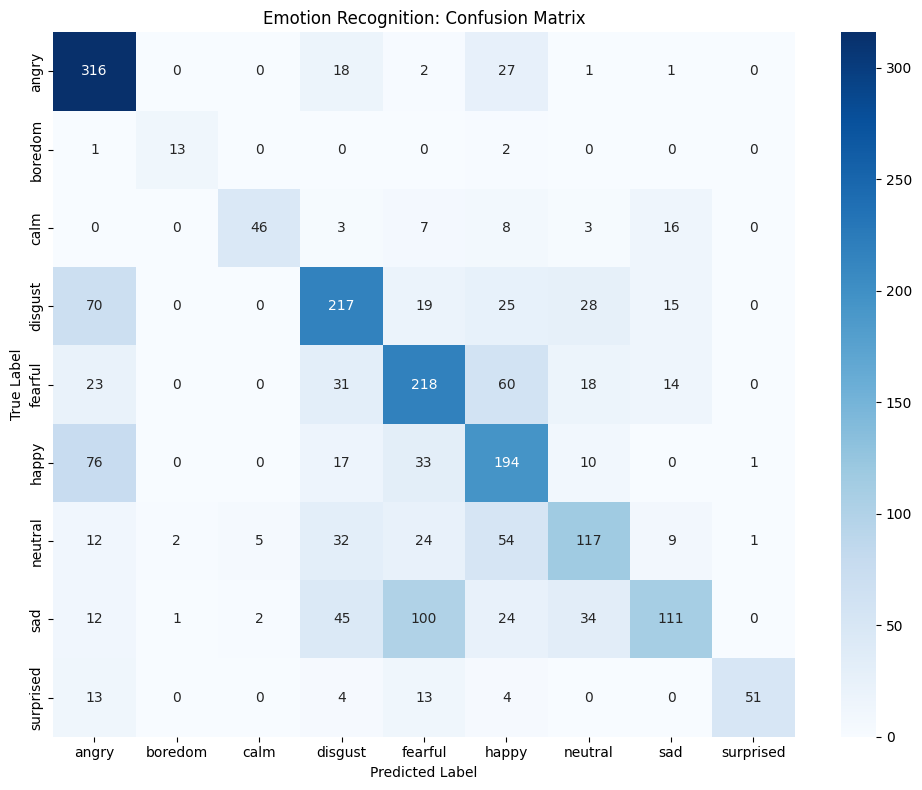


--- Accent Recognition Report ---
                        precision    recall  f1-score   support

       British English       0.98      1.00      0.99        90
       CREMA-D English       1.00      1.00      1.00      1461
                German       0.99      0.99      0.99       109
                Indian       1.00      1.00      1.00         5
North American English       1.00      1.00      1.00       608

              accuracy                           1.00      2273
             macro avg       0.99      1.00      1.00      2273
          weighted avg       1.00      1.00      1.00      2273



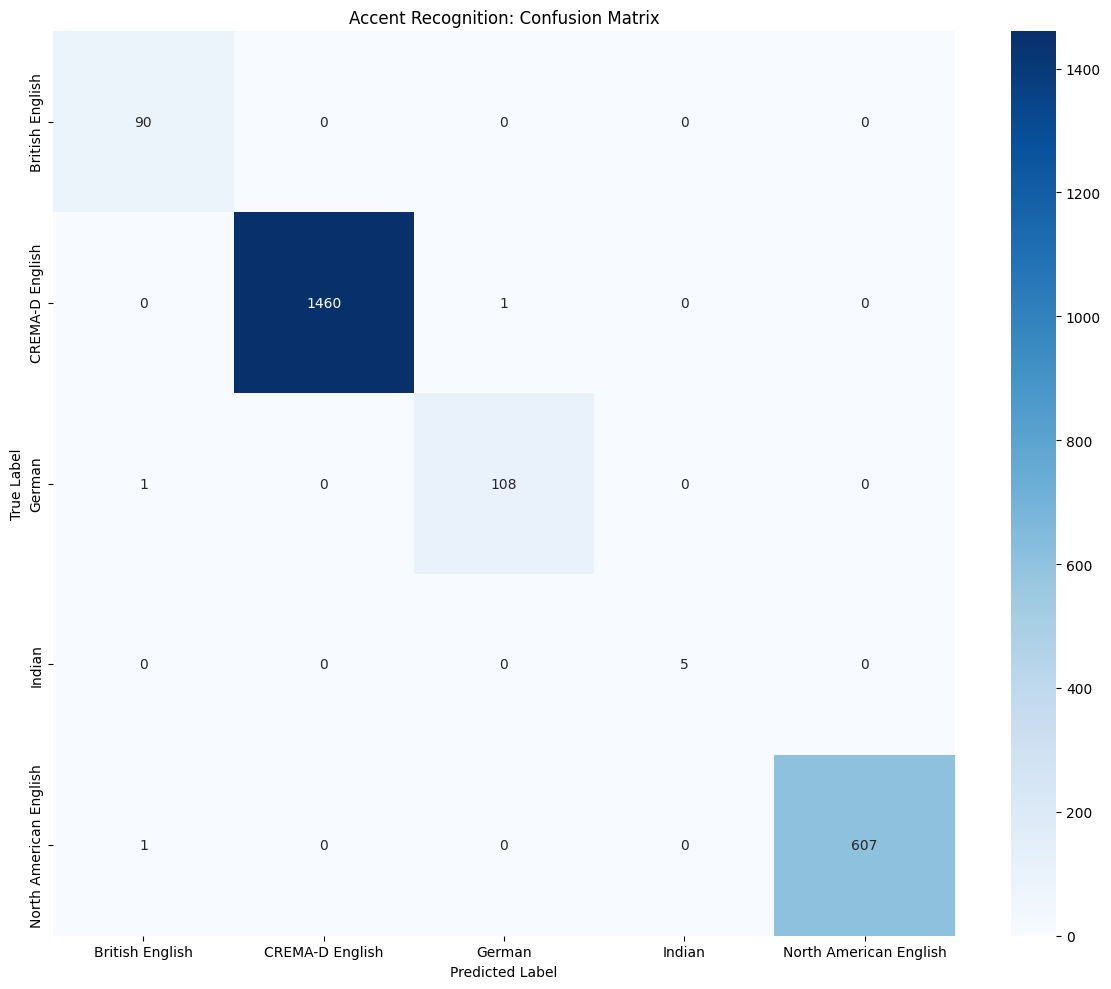


--- Gender Recognition Report ---
              precision    recall  f1-score   support

      female       0.85      0.45      0.59      1052
        male       0.66      0.93      0.77      1216

    accuracy                           0.71      2268
   macro avg       0.76      0.69      0.68      2268
weighted avg       0.75      0.71      0.69      2268



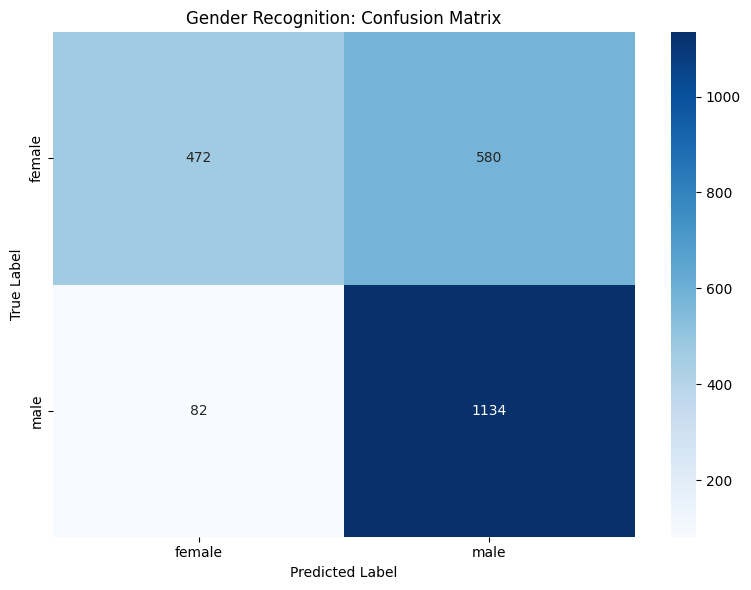

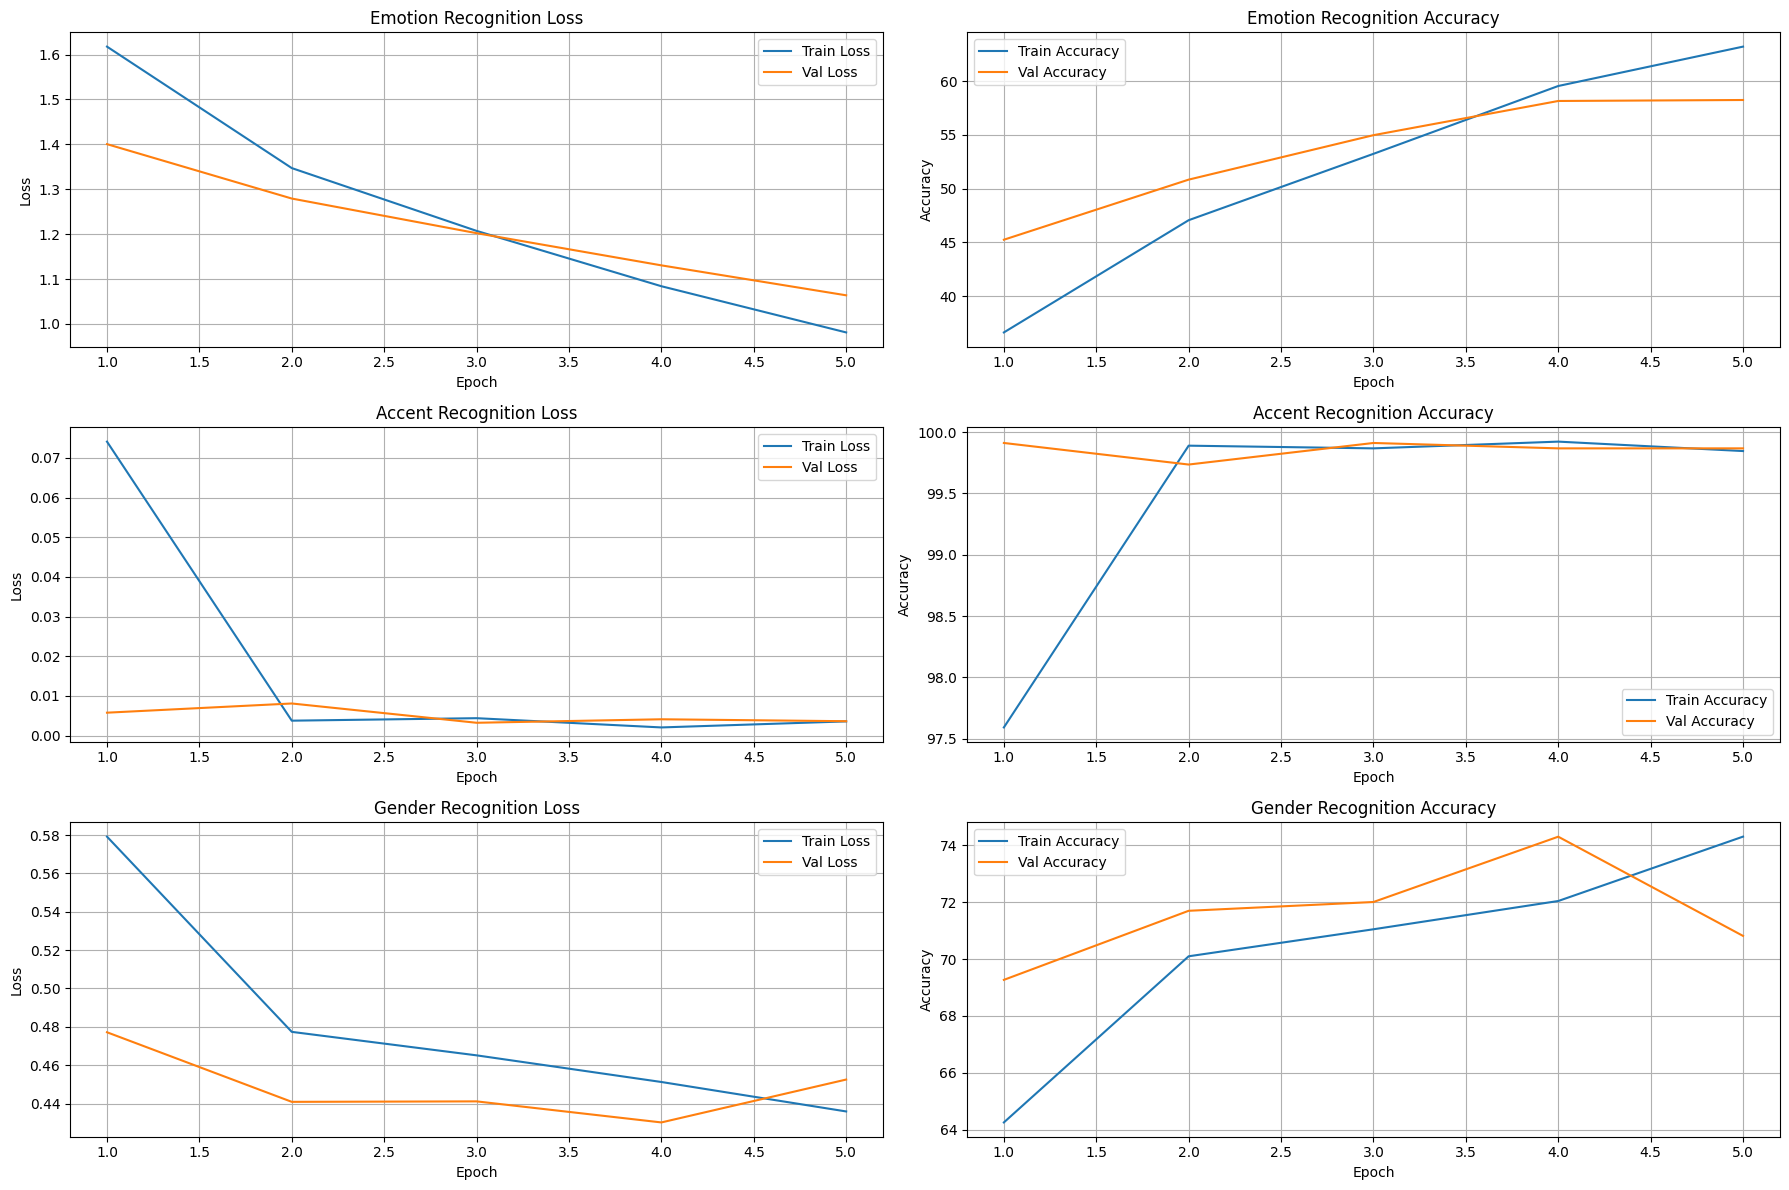

In [ ]:
# --- 6. Evaluation and Plotting ---
print("\n--- Evaluation and Plotting for Multi-Task Learning ---")

if 'mtl_model' in locals() and 'val_loader_mtl' in locals() and os.path.exists('best_mtl_model.pth'):
    # Load best model for final evaluation
    mtl_model.load_state_dict(torch.load('best_mtl_model.pth'))
    mtl_model.eval()

    all_emotion_true, all_emotion_pred = [], []
    all_accent_true, all_accent_pred = [], []
    all_gender_true, all_gender_pred = [], []

    with torch.no_grad():
        for features, emotion_labels, accent_labels, gender_labels in tqdm(val_loader_mtl, desc="Final MTL Evaluation"):
            features = features.to(device_mtl)
            emotion_labels = emotion_labels.to(device_mtl)
            accent_labels = accent_labels.to(device_mtl)
            gender_labels = gender_labels.to(device_mtl)

            emotion_preds, accent_preds, gender_preds = mtl_model(features)

            _, predicted_emotion = torch.max(emotion_preds.data, 1)
            _, predicted_accent = torch.max(accent_preds.data, 1)
            _, predicted_gender = torch.max(gender_preds.data, 1)

            # Collect predictions and true labels for valid (non-'unknown') samples
            valid_emotion_indices = (emotion_labels != emotion_ignore_index)
            all_emotion_true.extend(emotion_labels[valid_emotion_indices].cpu().numpy())
            all_emotion_pred.extend(predicted_emotion[valid_emotion_indices].cpu().numpy())

            valid_accent_indices = (accent_labels != accent_ignore_index)
            all_accent_true.extend(accent_labels[valid_accent_indices].cpu().numpy())
            all_accent_pred.extend(predicted_accent[valid_accent_indices].cpu().numpy())

            valid_gender_indices = (gender_labels != gender_ignore_index)
            all_gender_true.extend(gender_labels[valid_gender_indices].cpu().numpy())
            all_gender_pred.extend(predicted_gender[valid_gender_indices].cpu().numpy())

    # Check if there are any valid samples to report for each task
    if len(all_emotion_true) > 0:
        print("\n--- Emotion Recognition Report ---")
        # Filter target names to only include classes that actually appeared in the true labels
        unique_emotion_true_labels = np.unique(all_emotion_true)
        emotion_target_names = [emotion_le.classes_[i] for i in unique_emotion_true_labels]
        print(classification_report(all_emotion_true, all_emotion_pred, target_names=emotion_target_names, zero_division=0))
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix(all_emotion_true, all_emotion_pred), annot=True, fmt='d', cmap='Blues',
                    xticklabels=emotion_target_names, yticklabels=emotion_target_names)
        plt.title('Emotion Recognition: Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo valid emotion samples for final evaluation report.")

    if len(all_accent_true) > 0:
        print("\n--- Accent Recognition Report ---")
        unique_accent_true_labels = np.unique(all_accent_true)
        accent_target_names = [accent_le.classes_[i] for i in unique_accent_true_labels]
        print(classification_report(all_accent_true, all_accent_pred, target_names=accent_target_names, zero_division=0))
        plt.figure(figsize=(12, 10))
        sns.heatmap(confusion_matrix(all_accent_true, all_accent_pred), annot=True, fmt='d', cmap='Blues',
                    xticklabels=accent_target_names, yticklabels=accent_target_names)
        plt.title('Accent Recognition: Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo valid accent samples for final evaluation report.")

    if len(all_gender_true) > 0:
        print("\n--- Gender Recognition Report ---")
        unique_gender_true_labels = np.unique(all_gender_true)
        gender_target_names = [gender_le.classes_[i] for i in unique_gender_true_labels]
        print(classification_report(all_gender_true, all_gender_pred, target_names=gender_target_names, zero_division=0))
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(all_gender_true, all_gender_pred), annot=True, fmt='d', cmap='Blues',
                    xticklabels=gender_target_names, yticklabels=gender_target_names)
        plt.title('Gender Recognition: Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo valid gender samples for final evaluation report.")

    # Plotting training/validation losses and accuracies for each task
    if len(train_emotion_losses) > 0: # Check if training actually ran
        epochs_range_mtl = range(1, len(train_emotion_losses) + 1)

        plt.figure(figsize=(18, 12))

        # Emotion Plots
        plt.subplot(3, 2, 1)
        plt.plot(epochs_range_mtl, train_emotion_losses, label='Train Loss')
        plt.plot(epochs_range_mtl, val_emotion_losses, label='Val Loss')
        plt.title('Emotion Recognition Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(3, 2, 2)
        plt.plot(epochs_range_mtl, train_emotion_accs, label='Train Accuracy')
        plt.plot(epochs_range_mtl, val_emotion_accs, label='Val Accuracy')
        plt.title('Emotion Recognition Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Accent Plots
        plt.subplot(3, 2, 3)
        plt.plot(epochs_range_mtl, train_accent_losses, label='Train Loss')
        plt.plot(epochs_range_mtl, val_accent_losses, label='Val Loss')
        plt.title('Accent Recognition Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(3, 2, 4)
        plt.plot(epochs_range_mtl, train_accent_accs, label='Train Accuracy')
        plt.plot(epochs_range_mtl, val_accent_accs, label='Val Accuracy')
        plt.title('Accent Recognition Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Gender Plots
        plt.subplot(3, 2, 5)
        plt.plot(epochs_range_mtl, train_gender_losses, label='Train Loss')
        plt.plot(epochs_range_mtl, val_gender_losses, label='Val Loss')
        plt.title('Gender Recognition Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(3, 2, 6)
        plt.plot(epochs_range_mtl, train_gender_accs, label='Train Accuracy')
        plt.plot(epochs_range_mtl, val_gender_accs, label='Val Accuracy')
        plt.title('Gender Recognition Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("No training history to plot.")

else:
    print("Cannot perform final evaluation: Best MTL model not found or data loaders not initialized.")